
# Neumann conditions 

# Definition:


$$
-\frac{\partial u}{\partial n}=g(\mathbf{x})
$$


or

$$\nabla u \cdot \hat{n}=g(\mathbf{x})$$

over some boundary


$$\partial\Omega_N$$


# What Complete Problem Looks like:

$$
u(\mathbf{x})=u_D(\mathbf{x}) \qquad\text{on } \partial\Omega_D,
$$

$$
-\frac{\partial u}{\partial n}(\mathbf{x})=g(\mathbf{x}) \qquad \text{on }∂\Omega_N
$$


$$
\partial\Omega=\partial\Omega_D+\partial\Omega_N
$$



# Aproach : Through Weak Form

## Green's identity a.k.a. 
## Multivariable Integration by Parts :
$$
-\int_\Omega (\nabla^2u)v~\mathrm{d} x = \int_\Omega \nabla u \cdot \nabla v ~\mathrm{d} x - \int_{\partial\Omega}\frac{\partial u}{\partial n}v~\mathrm{d}s,
$$

Trying to write it in 1d is a good exercise, since there it reduces to integration by parts


$$
 \int_{\partial\Omega}\frac{\partial u}{\partial n}v~\mathrm{d}s=  \int_{\partial\Omega_N}\frac{\partial u}{\partial n}v~\mathrm{d}s +\int_{\partial\Omega_D}\frac{\partial u}{\partial n}v~\mathrm{d}s,
$$


We set $v=0$ on $\Omega_D$,

$$
 \int_{\partial\Omega}\frac{\partial u}{\partial n}v~\mathrm{d}s=  \int_{\partial\Omega_N}\frac{\partial u}{\partial n}v~\mathrm{d}s 
$$


# Hello World of FEA --> Poisson's equation


$$
-\nabla^2 u =f \qquad \text{in } \Omega,
$$
$$
u=u_D \qquad\text{on } \partial\Omega_D,
$$
$$
-\frac{\partial u}{\partial n}=g \qquad \text{on }\partial\Omega_N
$$


# Weak Form Derivation

$$
-\int_\Omega (\nabla^2u)v~\mathrm{d} x = \int_\Omega \nabla u \cdot \nabla v ~\mathrm{d} x - \int_{\partial\Omega}\frac{\partial u}{\partial n}v~\mathrm{d}s,
$$

$$
v=0 \text{ on } \partial\Omega_D
$$


$$
- \int_{\partial\Omega}\frac{\partial u}{\partial n}v~\mathrm{d}s= - \int_{\partial\Omega_N}\frac{\partial u}{\partial n}v~\mathrm{d}s =\int_{\partial\Omega_N} gv~\mathrm{d}s,
$$


At the end,

$$
    \int_\Omega \nabla u \cdot \nabla v~\mathrm{d} x = \int_\Omega fv~\mathrm{d} x - \int_{\partial\Omega_N}gv~\mathrm{d}s.
$$
Expressing this equation in the standard notation $a(u,v)=L(v)$ is straight-forward with 

$$
    a(u,v) = \int_{\Omega} \nabla u \cdot \nabla v ~\mathrm{d} x,\\
$$
$$
L(v) = \int_{\Omega} fv ~\mathrm{d} x - \int_{\partial\Omega_N} gv~\mathrm{d} s.
$$




---

Neumann Boundary Conditions show up only in 2nd order or higher problems because, it is a statement about first order derivatives. The Neumann problem is a first order differential equation itself.

---

Now let's solve a trial problem where we start with a solution
$u(x,y)=1+x^2y^2$ and manufacture a problem for it. 

It has a name:


**Method of Manufactured Solutions**

---

In [2]:
# please run this twice
try:
    import dolfinx
except ImportError:
    !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/9b21f39/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [3]:
import pyvista

Pyvista is another visualisation package just like viskex, but its better.
Reference:
https://docs.pyvista.org/

In [4]:
import numpy as np

# numpy helps with efficient vector and matrix operations

# With |library_name import command_name| code, we can directly use comman_name  

from dolfinx.fem import (Constant, Function, FunctionSpace, 
                         assemble_scalar, dirichletbc, form, locate_dofs_geometrical)


from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import create_unit_square
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import SpatialCoordinate, TestFunction, TrialFunction, dot, ds, dx, grad

Library Updates Done

In [5]:
mesh = create_unit_square(MPI.COMM_WORLD, 10, 10)
V = FunctionSpace(mesh, ("CG", 1))
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v)) * dx

Next is Dirichlet Condition

In [6]:
def u_exact(x):
    return 1 + (x[0]**2)*(x[1]**2)
# the targeted solution

def boundary_D(x):
    return np.logical_or(np.isclose(x[0], 0), np.isclose(x[0],1))
# the dirichlet boundary marker
# check out the np.isclose function online, it just compares and gives the output


dofs_D = locate_dofs_geometrical(V, boundary_D)
u_bc = Function(V)
u_bc.interpolate(u_exact)
bc = dirichletbc(u_bc, dofs_D)

For Neumann, we want g=0 on y=0 and g=-4 on y=1

any function g works as long as g(x,0)=0 and g(x,1)=-4

A trial function is g=-4y

we need to get the force

In [7]:
x = SpatialCoordinate(mesh)
from ufl import div


expr=1+(x[0]**2)*(x[1]**2)
f=div(grad(expr))
g=-1*x[1]

L = f * v * dx - g * v * ds

next is assembly and solution

In [8]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

V2 = FunctionSpace(mesh, ("CG", 2))
uex = Function(V2)
uex.interpolate(u_exact)
error_L2 = assemble_scalar(form((uh - uex)**2 * dx))
error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(error_L2, op=MPI.SUM))

u_vertex_values = uh.x.array
uex_1 = Function(V)
uex_1.interpolate(uex)
u_ex_vertex_values = uex_1.x.array
error_max = np.max(np.abs(u_vertex_values - u_ex_vertex_values))
error_max = MPI.COMM_WORLD.allreduce(error_max, op=MPI.MAX)
print(f"Error_L2 : {error_L2:.2e}")
print(f"Error_max : {error_max:.2e}")

Error_L2 : 2.79e-01
Error_max : 5.89e-01


Got the following code from pyvista website:

https://tutorial.pyvista.org/getting-started.html

In [9]:
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq

pyvista.global_theme.jupyter_backend = 'static'
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

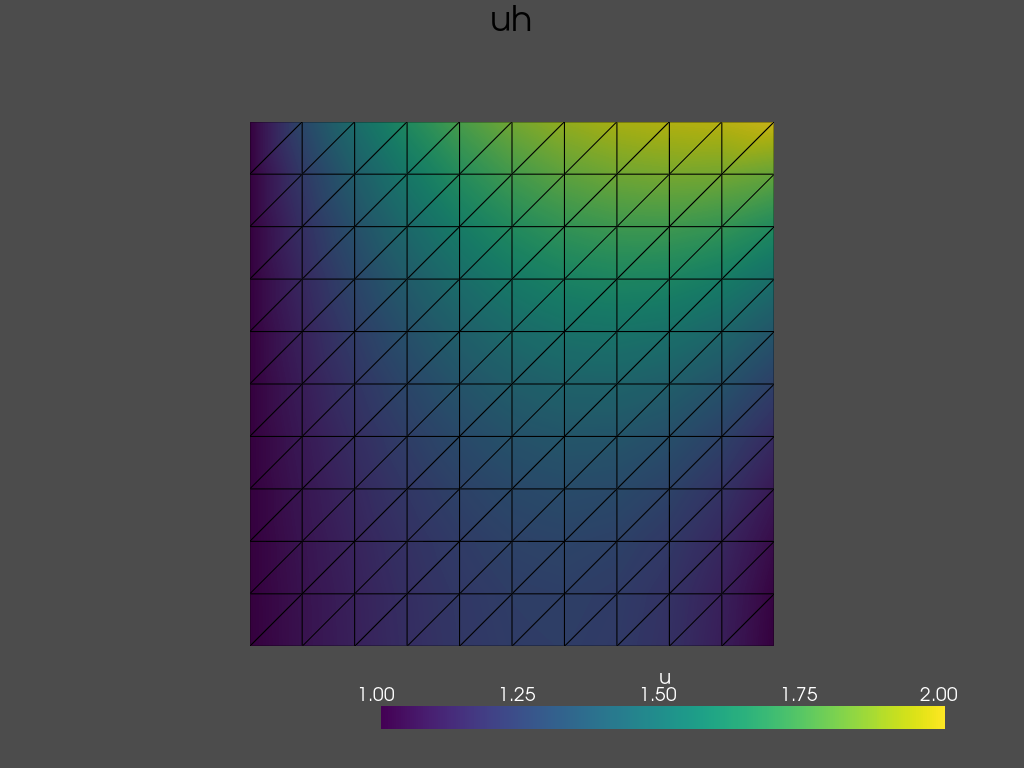

In [10]:
from dolfinx.plot import create_vtk_mesh
pyvista_cells, cell_types, geometry = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u"] = uh.x.array
grid.set_active_scalars("u")

plotter = pyvista.Plotter()
plotter.add_text("uh", position="upper_edge", font_size=14, color="black")
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("neumann_dirichlet.png")